In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics import tsaplots
from tabulate import tabulate
import scipy.io
from scipy import stats
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

# Task 1: Poisson neuron

In [32]:
# Set figure dimensions
plt.rcParams["figure.figsize"] = [10, 15]

## Section A

_Deviations from Poisson neuron model:_

_The use of logarithmic scale autocorrelation:_

Bin number is related to log of temporal interval. int means integer truncation and alpha constant that determines width ratio of successive bins.

(1) bin number: $n(i, j) = int[\frac{1}{\alpha}log_{10}(t_j - t_i)],\quad j > i$

raw count histogram calculated by summing every pair of spikes in recording for intervals in the range of $1 \le \Delta t \le 1000$ ms.

(2) raw count histogram: $C(n) = \sum_{i=1}^{N-1}\sum_{j=i+1}^{N}n(i, j)$

normalisation of histogram by dividing by bin width $10^{\alpha (n+1)} - 10^{\alpha n}$ and total number of spikes squared $N^2$ and multiplying by duration of recording $T$. Reason is raw bin count is expected to linearly increase with $N^2$ and decrease with $T$.

(3) normalised histogram: $A(n) = \frac{T}{N^2}\frac{C(n)}{10^{\alpha (n+1)} - 10^{\alpha n}}$

1 in every bin (flat histogram) is Poisson limit. n times more than 1 means n times more spikes than expected from random firing.

A possible critique could involve that this approach is inappropriate for low firing rates, that is, low number of spikes, even though below 0.1Hz usefuleness to test is questionable (they talk about this in discussion page 6518)

_Comparison with Poisson neuron:_

autocorrelation function for Poisson neuron is expected to return flat histogram constant 1, whereas most of the spontaneuous activation in neurons from the study show variability and oscillations with some peaks and usually variance greater than mean. 

(4) goodness of fit: $g = \frac{1}{K - k + 1}\sum_{n=k}^{K}\frac{(A_n - 1)^2}{\sigma_{n}^{2}}$

## Section B

To assess the validity of Swindale's statements, three neurons with varying deviation from the Poisson neuron are simulated and several metrics, both quantitative and graphical, are evaluated. The three neurons consist of a Poisson neuron, a refractory neuron and a bursting neuron. All simulations were run for a duration of 90 seconds and a sampling rate of 1000 Hz.

In [33]:
# Set simulation parameters
freq = 1e-3
T = int(90 / freq)
r0 = freq * 55
ref_t = 5
rec_t = 6
burst_t = 6

The refractory neuron is characterised by a baseline firing rate of 55 spikes/s, a refractory period of 5 ms after every spike and a recovery period of 6 ms. Its spike train and ISIs are generated below.

In [34]:
# Simulate refractory neuron
refractory_train = []
refractory_isis = []

for t in range(T):

    if len(refractory_train) == 0:
        r = r0
        seq = 6
    elif refractory_train[t - 1] == 1:
        refractory_isis.append(seq + 1)
        seq = 0
    else:
        seq += 1

    if seq <= ref_t:
        r = 0
    else:
        r = r0 / rec_t * min(seq - ref_t, rec_t)
        
    spike = np.random.binomial(1, r)
    refractory_train.append(spike)

if refractory_train[0] != 1:
    refractory_isis = refractory_isis[1:]

if refractory_train[-1] != 1:
    refractory_isis = refractory_isis[:-1]

## Section C

The bursting neuron is characterised by a baseline firing rate of 55 spikes/s, a bursting period where the firing rate linearly increases up to 70 spikes/s for 5 ms after every spike and ultimately returns to baseline if no spike occured. Its spike train and ISIs are generated below.

In [35]:
# Simulate bursting neuron
burst_train = []
burst_isis = []

for t in range(T):

    if len(burst_train) == 0:
        seq = 0
    elif burst_train[t - 1] == 1:
        burst_isis.append(seq + 1)
        seq = 0
    else:
        seq += 1

    if seq <= burst_t:
        r = r0 + 0.015 / (burst_t - 1) * seq
    else:
        r = r0
        
    spike = np.random.binomial(1, r)
    burst_train.append(spike)

if burst_train[0] != 1:
    burst_isis = burst_isis[1:]

if burst_train[-1] != 1:
    burst_isis = burst_isis[:-1]

## Section D

The Poisson neuron serves as the control Poissonian condition and is only characterised by a constant firing rate of 55 spikes/s. Its spike train and ISIs are generated below.

In [82]:
# Simulate Poisson neuron
poisson_train = []
poisson_isis = []

for t in range(T):

    if len(poisson_train) == 0:
        seq = 0
    elif poisson_train[t - 1] == 1:
        poisson_isis.append(seq + 1)
        seq = 0
    else:
        seq += 1
        
    r = r0
    spike = np.random.binomial(1, r)
    poisson_train.append(spike)

if poisson_train[0] != 1:
    poisson_isis = poisson_isis[1:]

if poisson_train[-1] != 1:
    poisson_isis = poisson_isis[:-1]

## Section E

In [69]:
# Define functions to generate plots
def plot_train(train, axes):

    axes[0].plot(train, linewidth=0.05)

    axes[0].set_ylim([0, 1.5])
    axes[0].set_xticks(np.arange(0, 10) * 1e4, labels=np.arange(0, 10))
    axes[0].set_yticks([0, 1])

    axes[0].set_xlabel("Time in s")
    axes[0].set_ylabel("Neural Spike [0/1]")

def plot_tih(isis, axes):

    pdf, _, _ = axes[1].hist(isis, bins=np.arange(1, max(isis) + 1), density=True)

    axes[1].set_xlabel("ISI in ms")
    axes[1].set_ylabel("Probability")

    return pdf

def plot_logtih(isis, axes):

    axes[2].hist(isis, bins=np.logspace(np.log10(1), np.log10(1000), 201))
    axes[2].set_xscale("log")

    axes[2].set_xlabel("ISI in ms")
    axes[2].set_ylabel("Count")

def plot_survivor(isis, axes):

    axes[3].ecdf(isis, complementary=True)

    axes[3].set_xlabel("ISI in ms")
    axes[3].set_ylabel("Survivor(t)")

def plot_hazard(isis, pdf, axes):
    
    survivor = stats.ecdf(isis).sf

    hazard = pdf[pdf != 0] / survivor.probabilities
    axes[4].bar(survivor.quantiles, hazard)

    axes[4].set_xlabel("ISI in ms")
    axes[4].set_ylabel("Hazard(t)")

def plot_acf(isis, axes):

    fig = tsaplots.plot_acf(isis, lags=100, ax=axes[5], zero=False, auto_ylims=True, title=None)

    yticks_range = np.arange(-0.04, 0.05, 0.01)
    axes[5].set_yticks(yticks_range, labels=(1e3 * yticks_range).astype(int))

    axes[5].set_xlabel("Time Lag in ms")
    axes[5].set_ylabel("ACR in spikes/s")

def compute_fano(train):
    return np.var(train) / np.mean(train)

def compute_cv(isis):
    return np.std(isis) / np.mean(isis)

def plot_xcorr(train1, train2, axes, label):

    axes[6].xcorr(train1, train2, maxlags=100, usevlines=False, linestyle="-", label=label)

    yticks_range = np.arange(0, 0.11, 0.01)
    axes[6].set_yticks(yticks_range, labels=(1e3 * yticks_range).astype(int))

    axes[6].set_xlabel("Time Lag in ms")
    axes[6].set_ylabel("XCR in spikes/s")
    axes[6].legend(loc="upper left")

In [74]:
# Define main function to create multipanel figure
def study_neuron(train, isis, title, other_trains):

    fig, axes = plt.subplots(7)

    plot_train(train, axes)
    pdf = plot_tih(isis, axes)
    plot_logtih(isis, axes)
    plot_survivor(isis, axes)
    plot_acf(isis, axes)
    plot_hazard(isis, pdf, axes)

    for label, train2 in other_trains.items():
        plot_xcorr(train, train2, axes, label)

    fig.suptitle(f"{title} neuron")
    plt.tight_layout()

The three neurons are initially compared in terms of Fano Factor (FF) and Coefficient of Variation (CV), which provide an estimate of deviation of the spike train from the Poisson distribution and of the ISIs from the exponential distribution, respectively. For both measures, a value close to 1 indicates similarity to a Poisson neuron.

In [83]:
# View FF and CV for three neurons
titles = ["Poisson", "Refractory", "Bursting"]
fanos = [compute_fano(train) for train in [poisson_train, refractory_train, burst_train]]
cvs = [compute_cv(isis) for isis in [poisson_isis, refractory_isis, burst_isis]]

tab = {"Neuron": titles, "Fano Factor": fanos, "Coefficient of Variation": cvs}

print(tabulate(tab, headers="keys", floatfmt=".3f"))

Neuron        Fano Factor    Coefficient of Variation
----------  -------------  --------------------------
Poisson             0.945                       0.978
Refractory          0.962                       0.662
Bursting            0.942                       1.010


As expected, the Poisson neuron returns an FF and a CV relatively close to 1, and they should further approach 1 as the duration of the simulation increases. The refractory neuron deviates from the Poisson condition by its ISI distribution, as its CV is smaller than 1. In contrast, the bursting neuron returns similar FF and CV compared to the Poisson neuron.

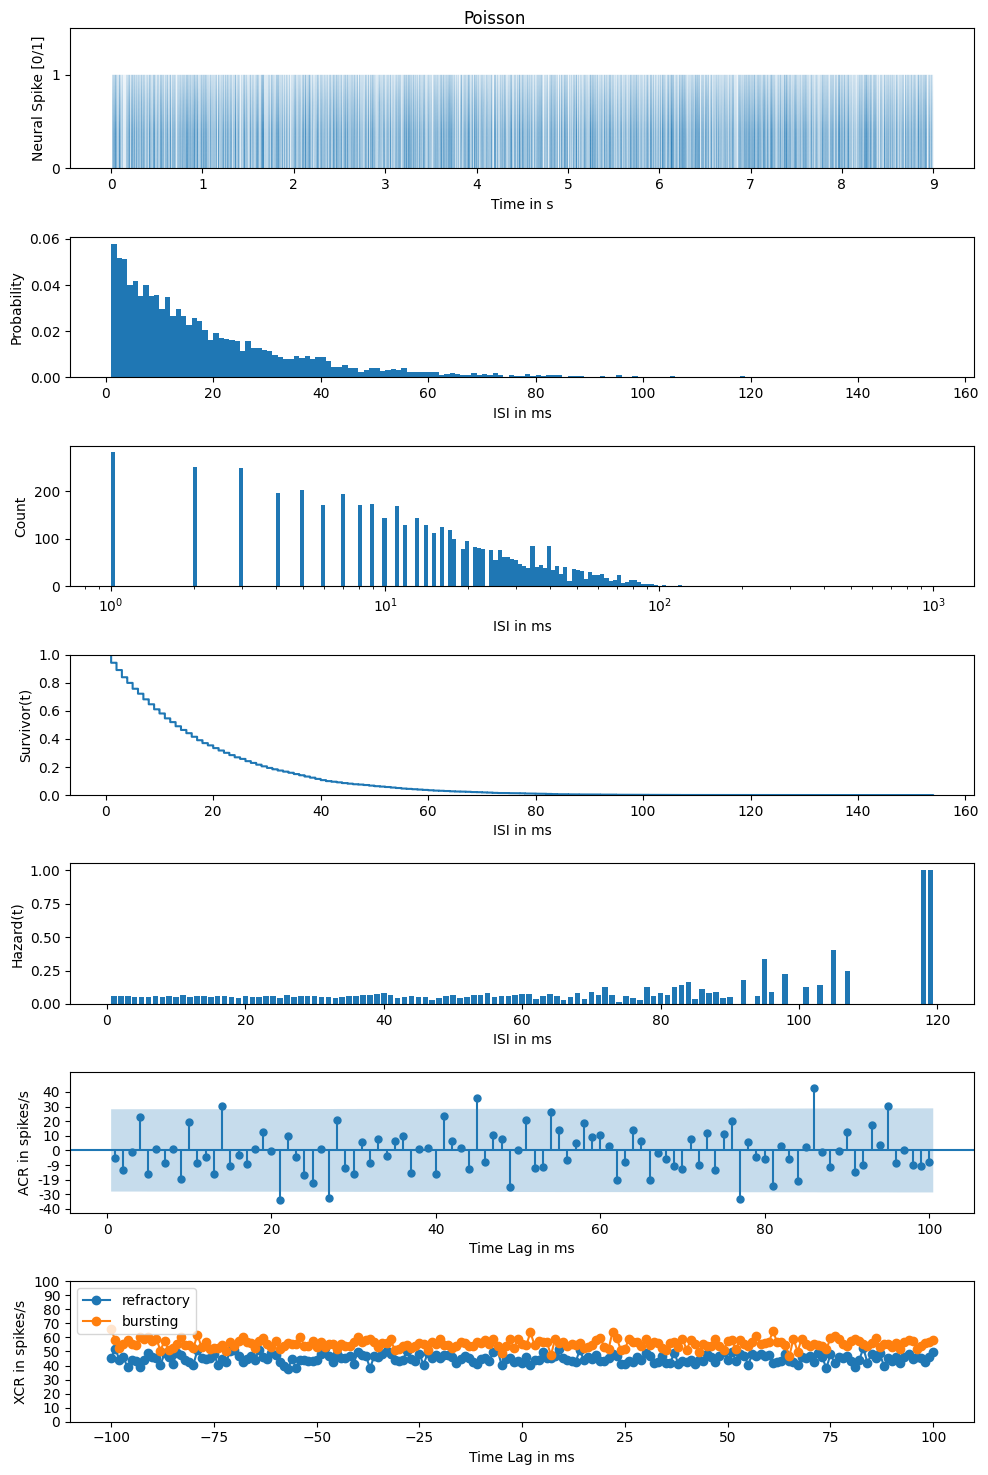

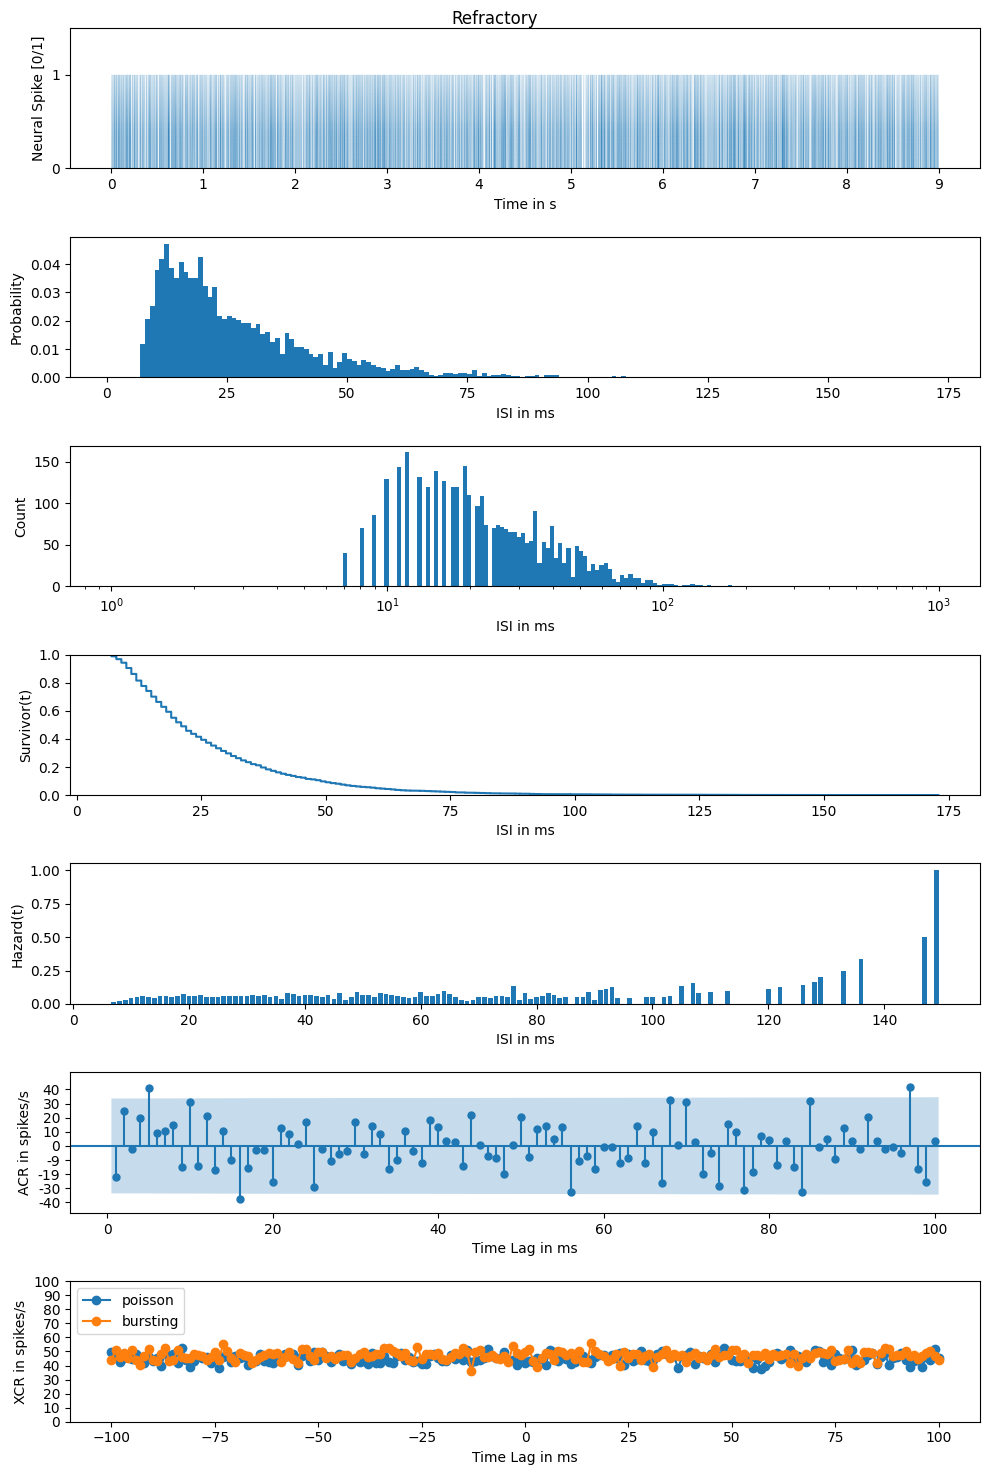

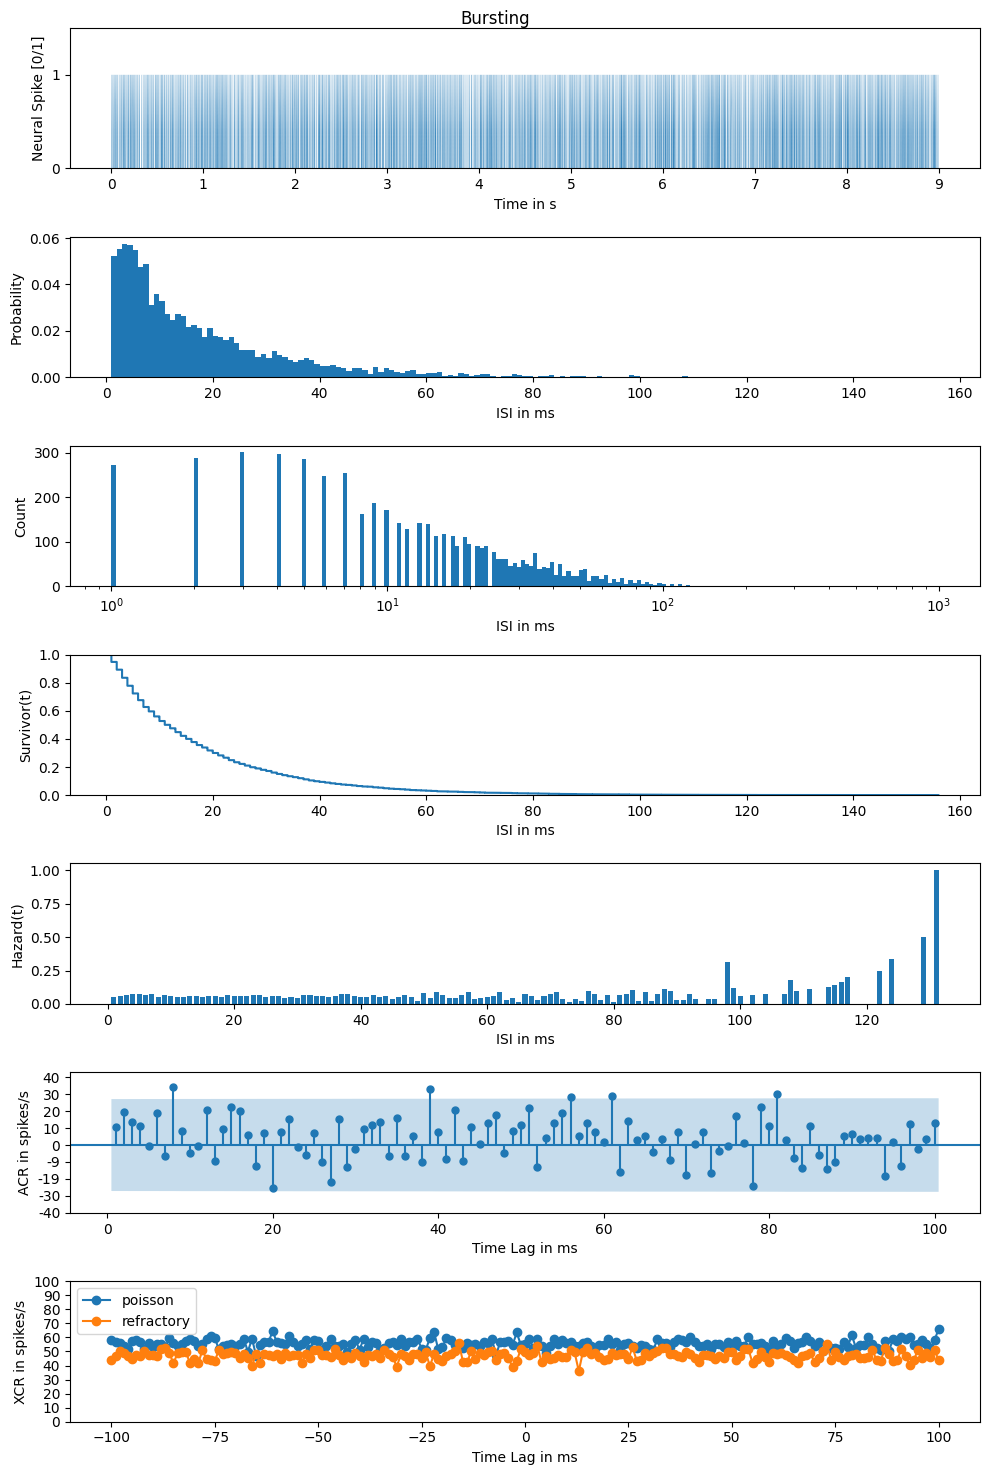

In [73]:
# Generate analytical plots for Poisson neuron
study_neuron(
    poisson_train, poisson_isis, titles[0], {"refractory": refractory_train, "bursting": burst_train}
)
# Generate analytical plots for refractory neuron
study_neuron(
    refractory_train, refractory_isis, titles[1], {"poisson": poisson_train, "bursting": burst_train}
)
# Generate analytical plots for bursting neuron
study_neuron(
    burst_train, burst_isis, titles[2], {"poisson": poisson_train, "refractory": refractory_train}
)

## Section F

Each figure above illustrates the spike train and ISI profile of the Poisson neuron, the refractory neuron and the bursting neuron, in such order. From top to bottom, each figure includes:

1. Spike train plot: visualisation of the binary spikes on the y axis over time on the x axis, for a duration of 9 seconds.
2. Temporal interval histogram (TIH): a histogram of the probabilities of ISIs shown on a Euclidean time scale.
3. xlog TIH: a histogram of the absolute counts of ISIs shown on a logarithmic time scale.
4. Survivor function $S(t)$: the probability of non-occurrence for each ISI given all previous ISIs did not occur either.
5. Hazard function $h(t)$: the probability of occurrence of each ISI given all previous ISIs did not occur.
6. Autocorrelation: the correlation of a spike train with itself for every timelag between 1 and 100 ms normalised to firing rate.
7. Cross-correlation: the correlation between two spike trains for every timelag between 1 and 100 ms normalised to firing rate.

Differences in the spike train plots between neurons are minimal. It seems that for the refractory neuron longer ISIs occur more frequently than for the Poisson and the bursting neuron. However, it cannot be clearly stated exclusively from the spike train plot. In contrast, the both the Euclidean and the log TIHs offer visual discrepancies between the neurons. In particular, the ISIs of the Poisson and the bursting neurons seem to decay exponentially, although the latter shows a higher probability for shorter ISIs than the former likely due to the bursting period. The log TIH can discriminate especially well the refractory neuron from the other two, because ISIs in the range of the refractory period (1-10 ms) show a virtually null probability, and the most frequent ISI only lies around 17 ms followed by an exponential decay similar to the other two neurons.

Also in the case of the survivor curve, the bursting neuron shares similarities with the Poisson neuron, whereas the refractory neuron does not. Unlike the other two, the survivor function of the refractory neuron starts descending at ISIs above 0 ms, roughly in the range of 10 ms. Compared to the other two neurons, the tail of the curve also stretches further by about 20 ms, which means that the refractory neuron can reach ISIs longer by about 20 ms, also visible in the TIH and the hazard curve. The hazard function provided subtle yet visible differences between both the refractory and the bursting neurons compared to the Poisson control. Specifically, the first and the second exhibited an smoother increase from low probabilities to unity for ISIs larger than 100 ms, whereas the increase was steeper for the Poisson neuron, which might indicate that refraction or bursting could introduce some degree of interdependence between adjacent ISIs.

The autocorrelations of the three neurons for lagtimes within 100 ms do not clearly differ from one another. Such observation goes against the results of Swindale et al, 2021, where they argued that autocorrelation indeed provides a good estimate of Poissonian behaviour, although unlike here they used a logarithmic scale for the time intervals. However, in the current results it is practically impossible to distinguish between refractory, bursting or Poisson neurons alike exclusively by inspecting their autocorrelation functions. The cross-correlations between the neurons stayed relatively constant over lagtimes within 100 ms. Interestingly, the average cross-correlation between the bursting neuron and the Poisson neuron appeared higher than that between the refractory neuron and the Poisson neuron. Thus, the divergence in cross-correlation might offer an additional alternative strategy to assess the similarity between a neuron under investigation and the Poisson control.

Overall, it seems that conditions slightly distant from Poissonian, such as refractory and bursting behaviour, cannot be easily determined by assessing their autocorrelation. Instead, methods such as TIH, hazard function and cross-correlation may represent a more powerful approach.

# Task 2: Encoding: GLM, optimal kernel and STA

In [2]:
# Set figure dimensions
plt.rcParams["figure.figsize"] = [10, 3]

## Section A

In [3]:
sta = scipy.io.loadmat("GLM/STA.mat")
spikeTrain = sta["spikeTrain"].flatten()
stimSig = sta["stimSig"].flatten()

In [4]:
freq = 2000
period = 1 / freq

n = spikeTrain.shape[0]
time = n * period

intervals = np.arange(0, time, period)

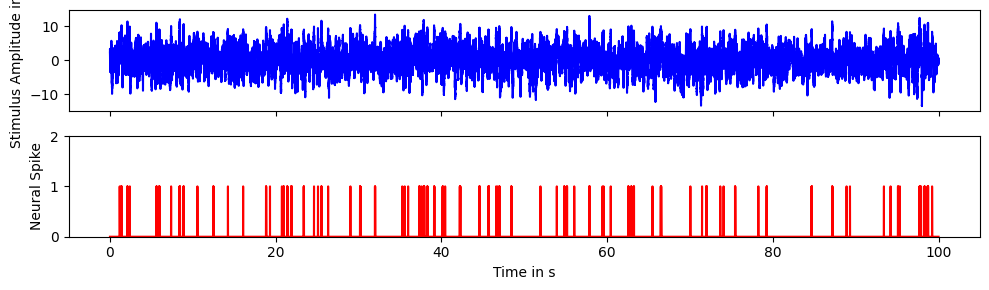

In [5]:
fig, axes = plt.subplots(2, sharex=True)

axes[0].plot(intervals, stimSig, c="b")
axes[1].plot(intervals, spikeTrain, c="r")

axes[1].set_ylim(0, 2)
axes[1].set_xlabel("Time in s")
axes[0].set_ylabel("Stimulus Amplitude in au")
axes[1].set_ylabel("Neural Spike")

plt.tight_layout()

In [6]:
def compute_sta(train, stimulus, window):

    stimulus_list = []
    indices = np.where(train == 1)[0]

    keep = np.where((indices >= window) & (indices <= len(stimulus) - window))
    indices = indices[keep]

    for idx in indices:
        spike_triggered_stimulus = stimulus[idx - window:idx + window + 1]
        stimulus_list.append(spike_triggered_stimulus)

    stimulus_arr = np.concatenate(stimulus_list).reshape(len(stimulus_list), 2 * window + 1)
    sta_means = np.mean(stimulus_arr, axis=0)
    sta_stds = np.std(stimulus_arr, axis=0)

    return sta_means, sta_stds

In [7]:
window_size = 0.5
window = int(window_size * freq)

sta_means, sta_stds = compute_sta(spikeTrain, stimSig, window)

Text(0, 0.5, 'Stimulus Amplitude in au')

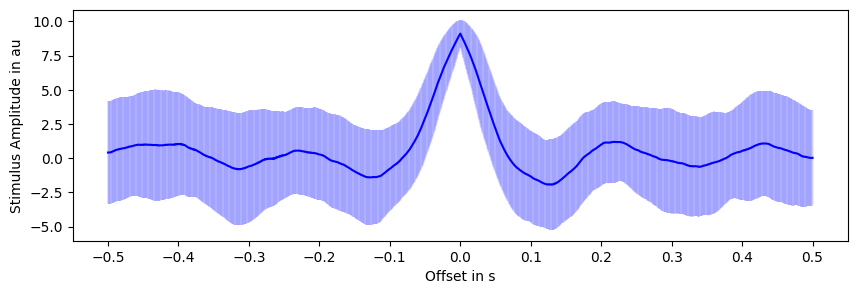

In [8]:
window_range = np.arange(-window_size, window_size + period, period)
xticks_range = np.arange(-window_size, window_size + 0.1, 0.1)

plt.errorbar(window_range, sta_means, yerr=sta_stds, elinewidth=0.1, c="b")

plt.xticks(xticks_range)
plt.xlabel("Offset in s")
plt.ylabel("Stimulus Amplitude in au")

Optimal frequency is around 500 s

In [20]:
np.sin(2 * np.pi * )

0.49975012493753124

## Section B

In [9]:
kernel = scipy.io.loadmat("GLM/kernel.mat")
stim = kernel["stim"].flatten()
resp = kernel["resp"]

In [10]:
freq = 1000
step = 1 / freq

n = resp.shape[1]
time = n * period

samples = np.arange(0, 60, step)
train = np.mean(resp, axis=0)

In [11]:
# Define function for computing and plotting firing rates with sliding square window
def plot_square(train, samples, window_size, c, step=0.001, mode="same"):

    window = np.ones(int(window_size / step))
    window /= sum(window)

    firing_rates = np.convolve(train, window, mode) / step
    plt.plot(samples, firing_rates, c=c, label=window_size)

    return firing_rates

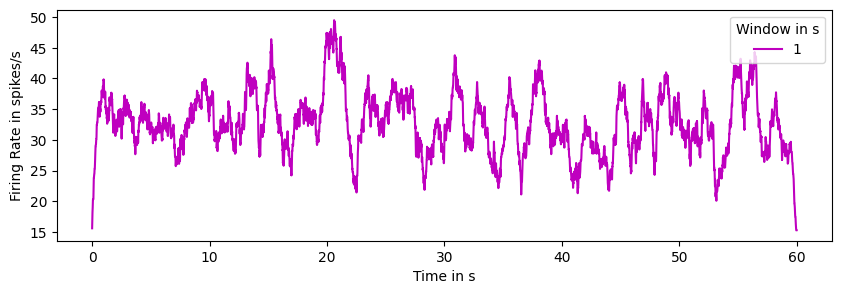

In [12]:
# Plot firing rates for different window sizes
# plot_square(train, samples, 0.3, "b")
# plot_square(train, samples, 0.5, "r")
# plot_square(train, samples, 0.7, "k")
# plot_square(train, samples, 1.3, "y")

firing_rates = plot_square(train, samples, 1, "m")

plt.xlabel("Time in s")
plt.ylabel("Firing Rate in spikes/s")
plt.legend(title="Window in s", loc="upper right")

In [13]:
window_size = 0.1
window = int(window_size * freq)

sta_arr = np.apply_along_axis(lambda train: compute_sta(train, stim, window), 1, resp)
sta_stats = np.mean(sta_arr, axis=0)

sta_means, sta_stds = sta_stats[0, :], sta_stats[1, :]

Text(0, 0.5, 'Stimulus Amplitude in au')

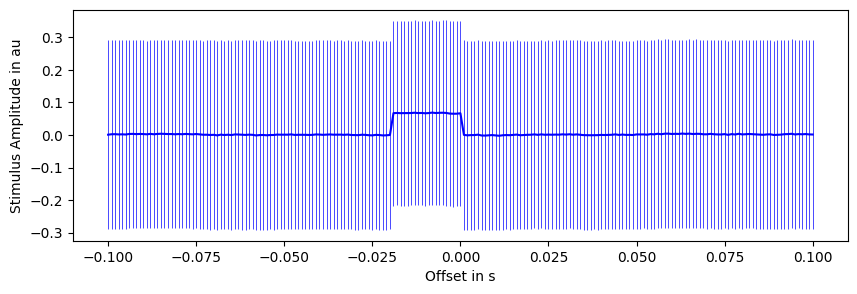

In [14]:
window_range = np.arange(-window_size, window_size + period, 2 * period)

plt.errorbar(window_range, sta_stats[0, :], yerr=sta_stats[1, :], elinewidth=0.5, c="b")

plt.xlabel("Offset in s")
plt.ylabel("Stimulus Amplitude in au")

$D_{opt}(t) = [\langle r \rangle\, \cdot\, STA(t)] : \sigma_{s}^{2}$

Text(0, 0.5, 'Not sure')

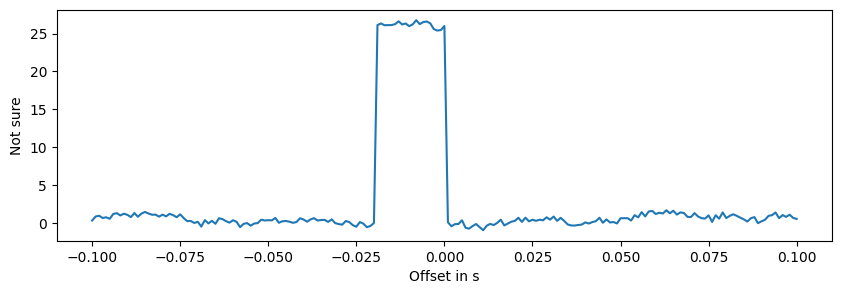

In [15]:
# calculate optimal kernel
opt_kernel = np.mean(firing_rates) * sta_means / np.var(stim)

plt.plot(window_range, opt_kernel)

plt.xlabel("Offset in s")
plt.ylabel("Not sure")

## Section C

$r_{est} = r_{0} + D(t)\, *\, s(t)$

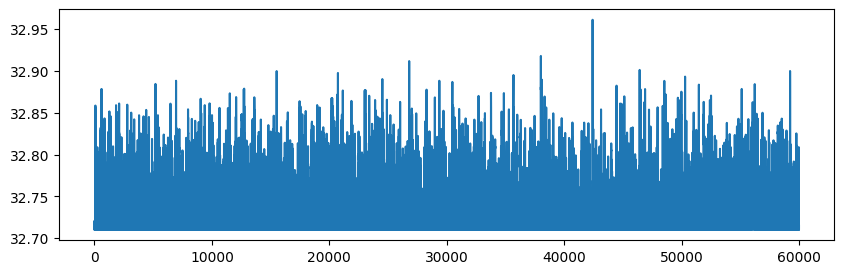

In [31]:
L = np.convolve(opt_kernel / np.sum(opt_kernel), stim, mode="same")
L = np.maximum(0, L)

plt.plot(np.mean(firing_rates) + L)
#plt.plot(firing_rates)

# Task 3: PSTH and ROC

In [2]:
# Set figure dimensions
plt.rcParams["figure.figsize"] = [10, 4]

## Section A

In [89]:
# Import datasets
sound_times = pd.read_csv("PSTH/sound_times.csv", header=None).to_numpy()
lick_times = pd.read_csv("PSTH/lick_times.csv", header=None).to_numpy()
spike_trains = pd.read_csv("PSTH/spike_trains.csv", header=None).to_numpy()

In [90]:
# Define function to process spike train into based on stimulus array and trial window
def process_spike_trains(spike_trains, event_times, trial_window):

    trial_list = []
    event_idx = np.round(event_times * 1e3).astype(int)

    for i in range(spike_trains.shape[1]):
        
        if i in event_idx:

            trial = spike_trains[:, i + trial_window[0]:i + trial_window[1]]
            trial_list.append(trial)

    spike_arr = np.hstack(trial_list).reshape(4, len(trial_list), -1)
    psth_vals = 1000 * np.mean(spike_arr, axis=1)

    return spike_arr, psth_vals

# Define function to generate a raster plot given a trial window
def plot_raster(arr, trial_window, ax):

    spike_list = [np.where(arr[i, :])[0] for i in range(arr.shape[0])]

    ax.eventplot(spike_list, colors="k")
    ax.axvline(x=-trial_window[0], color="r", linestyle="--")

    ax.set_ylabel("Trial")

# Define function to generate a PSTH given a trial window
def plot_psth(psth_vals, trial_window, ax):
    
    trial_range = np.arange(trial_window[0], trial_window[1], 100) / 1000
    time_range = np.arange(0, trial_window[1] - trial_window[0])
    xticks_range = np.arange(0, trial_window[1] - trial_window[0], 100)

    ax.bar(time_range, psth_vals, color="k")
    ax.axvline(x=-trial_window[0], color="r", linestyle="--")

    ax.set_xticks(ticks=xticks_range, labels=trial_range)
    ax.set_xlabel("Offset in s")
    ax.set_ylabel("Firing Rate in spikes/s")

In [91]:
# Process spike train with window around sound event
trial_window = [-200, 1001]
spike_arr, psth_vals = process_spike_trains(spike_trains, sound_times, trial_window)

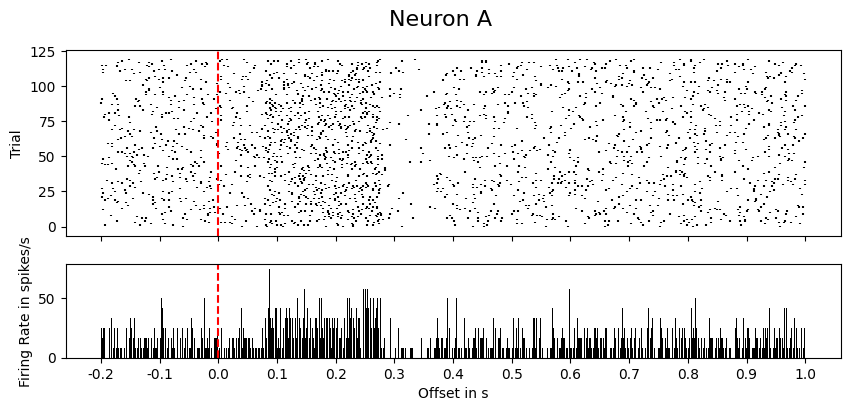

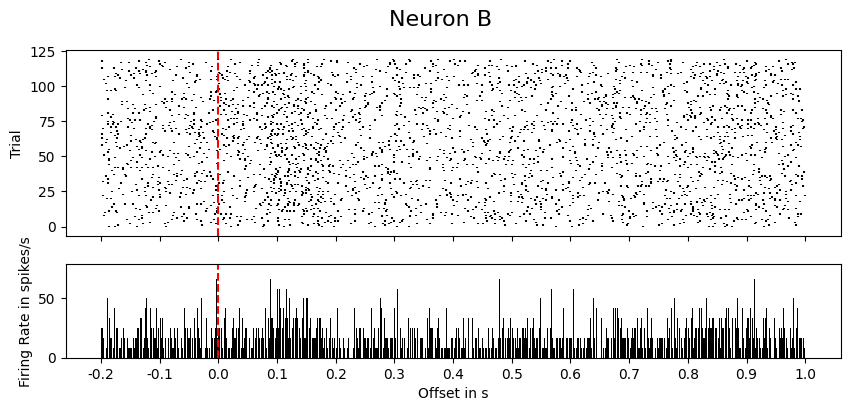

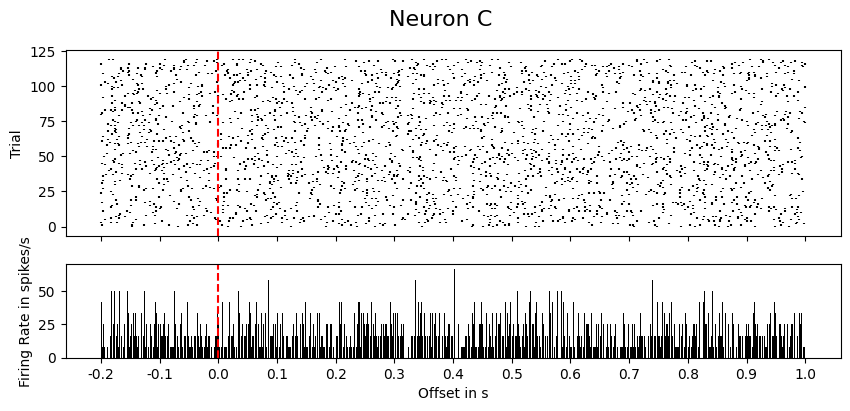

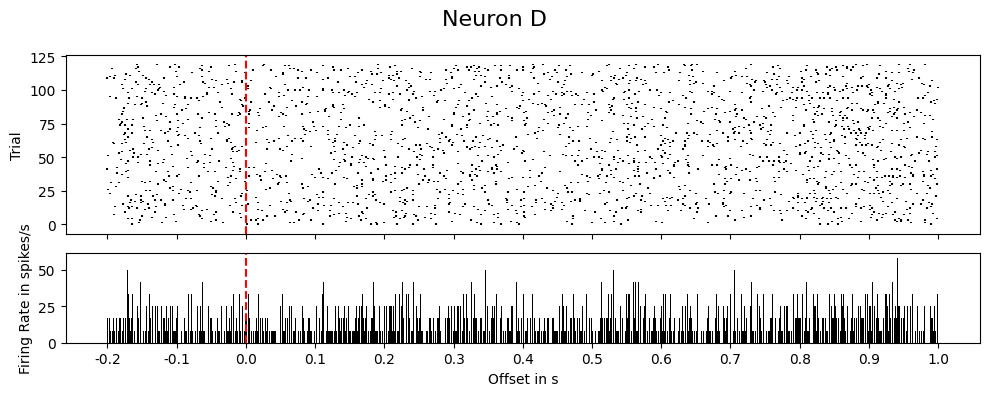

In [23]:
# Visualise raster plot and PSTH for each neuron for window around sound event
for i in range(spike_trains.shape[0]):

    fig, axes = plt.subplots(2, sharex=True, height_ratios=[2, 1])

    plot_raster(spike_arr[i], trial_window, axes[0])
    plot_psth(psth_vals[i], trial_window, axes[1])

    fig.suptitle(f"Neuron {'ABCD'[i]}", fontsize=16)

plt.tight_layout()

## Section B

Based on the figures, there seems to be an increase in firing rate after the sound stimulus for neurons A and B, but not for neurons C and D. In particular, neuron A exhibits an increase in average firing rate from about 15 spikes/s to about 40 spikes/s between 100 and 300 ms after the stimulus onset, followed by a sharp refractory period of about 100 ms. Neuron B shows a similar response, but limited to a window between 100 and 200 ms after the stimulus onset and with a shorter and less evident refractory period. The average firing rate of neurons C and D appeared unchanged upon the stimulus onset, and it continues to fluctuate in a stochastic manner over the entire window. In conclusion, neuron A and to a less extent neuron B experienced an increase in average firing rate after stimulus onset, whereas neurons C and D did not seem to respond to the stimulus and maintained their baseline firing pattern.

## Section C

In [92]:
# Process spike train with window around sound event
trial_window = [-500, 501]
spike_arr, psth_vals = process_spike_trains(spike_trains, lick_times, trial_window)

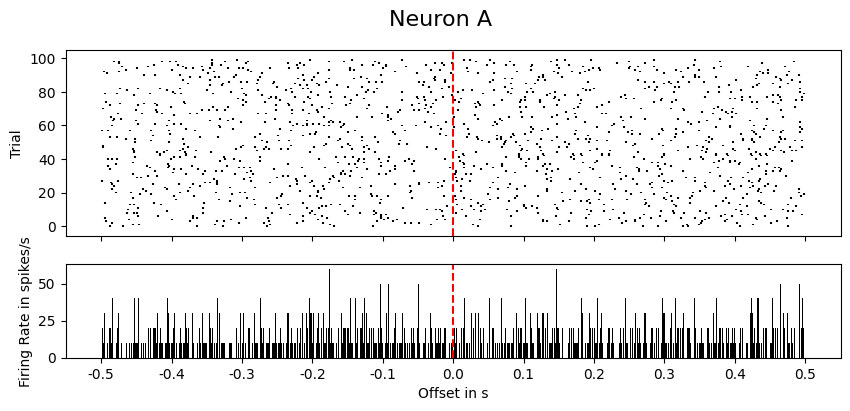

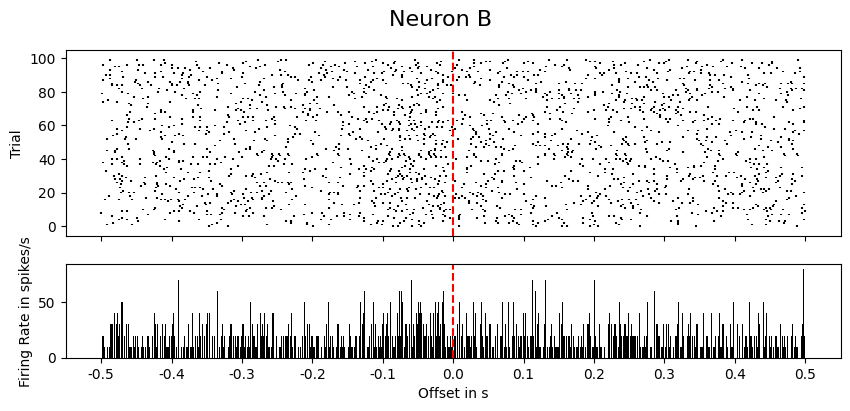

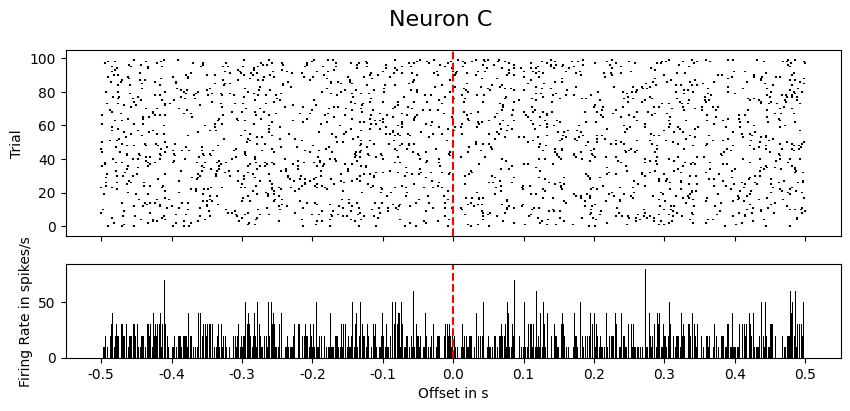

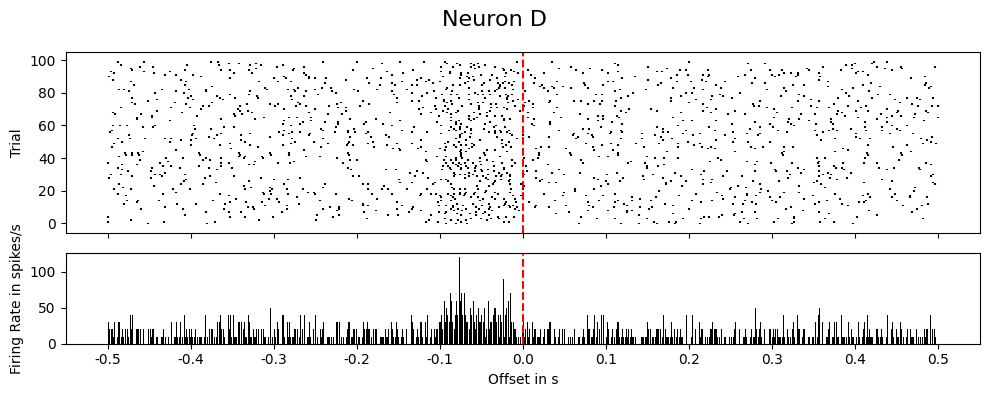

In [93]:
# Visualise raster plot and PSTH for each neuron for window around sound event
for i in range(spike_trains.shape[0]):

    fig, axes = plt.subplots(2, sharex=True, height_ratios=[2, 1])

    plot_raster(spike_arr[i], trial_window, axes[0])
    plot_psth(psth_vals[i], trial_window, axes[1])

    fig.suptitle(f"Neuron {'ABCD'[i]}", fontsize=16)

plt.tight_layout()

Based on the figures above, neurons B and D exhibit an increased firing rate in the 100 ms prior to licking, whereas neurons A and C show a relatively unchanged firing pattern over the entire trial. Remarkably, neurons B and D experience an increase in average firing rate from about 15 spikes/s to about 40 spikes/s only within 100 ms prior to licking. However, their firing pattern seems slightly refracted in the 10 ms prior to licking and ultimately returns to normality during and after licking. Such behaviour may suggest that these two neurons are involved in the intention and planning of licking. In conclusion, neurons B and D, but not neurons A and C show sensitivity to licking in the 100 ms before the action itself.

## Section D

In [3]:
# Import dataset
lick_df = pd.read_csv("PSTH/fr_pre_licks.csv")

In [4]:
# Evaluate mismatch between true and predicted licks
lick_df["pred"] = lick_df["fr_100ms_pre"] >= 20
lick_df["pred"] = lick_df["pred"].astype(int)
lick_df["divergence"] = lick_df["lick"] - lick_df["pred"]

In [5]:
# Define function to calculate accuracy
def find_accuracy(group):

    accuracy = 1 - np.abs(group["divergence"]).sum() / group["lick"].count()
    return 100 * accuracy

# Define function to calculate false positive rate
def find_fpr(group):

    false_positives = np.sum(np.where((group["lick"] == 0) & (group["pred"] == 1), 1, 0))
    true_negatives = np.sum(np.where((group["lick"] == 0) & (group["pred"] == 0), 1, 0))

    false_positive_rate = false_positives / (false_positives + true_negatives)
    return 100 * false_positive_rate

# Define function to calculate true positive rate
def find_tpr(group):

    true_positives = np.sum(np.where((group["lick"] == 1) & (group["pred"] == 1), 1, 0))
    false_negatives = np.sum(np.where((group["lick"] == 1) & (group["pred"] == 0), 1, 0))

    true_positive_rate = true_positives / (true_positives + false_negatives)
    return 100 * true_positive_rate

In [6]:
# Summarise predictive performance for every neuron with a threshold of 20 spikes/s
gr_lick_df = lick_df.groupby("neuron")
acc = gr_lick_df.apply(find_accuracy).to_list()
fpr = gr_lick_df.apply(find_fpr).to_list()
tpr = gr_lick_df.apply(find_tpr).to_list()

tab = {"Neuron": "ABCD", "ACC (%)": acc, "FPR (%)": fpr, "TPR (%)": tpr}

print(tabulate(tab, headers="keys"))

Neuron      ACC (%)    FPR (%)    TPR (%)
--------  ---------  ---------  ---------
A                50          2          2
B                60         80        100
C                48         18         14
D                95          0         90


The response of neurons to licking was predicted based on the average firing rate in the 100 ms preceding the licking event. The table above summarises predictive performance for the four neurons (A - D) with a threshold of 20 spikes/s. In other words, if the average firing rate is greater or equal to the threshold, a licking event is predicted and vice versa. Performance is measured in terms of overall accuracy (ACC), false positive rate (FPR) and true positive rate (TPR).

Performance varied across neurons. The best predictions were observed for neuron D, with 95% of the samples correctly predicted, no false positives as well as relatively high sensitivity (90% true positives). This suggests that the firing rate of neuron D tends to increase prior to licking. The second best performance was obtained for neuron B, with a 60% accuracy, a poor 80% FPR and an optimal TPR of 100%. This indicates that the firing rate of neuron B is usually higher than 20 spikes/s regardless of licking. As a result, sensitivity for neuron B was better than for neuron D, but the much larger FPR for the former resulted in a lower overall accuracy.

Predictions for neuron A are comparable to random choice (50% accuracy). While a relatively low FPR of 2% almost rivals with that of neuron D, a TPR of 2% signals that this neuron is characterised by a firing rate generally lower than 20 spikes/s regardless of licking. Finally, performance was lowest for neuron C, with an accuracy of 48%, an FPR of 18% and a TPR of 14%. For this neuron, firing rates lower or higher than the threshold occurr with similar probability regardless of licking, and thus firing rate seems clearly unrelated to licking events.

## Section E

In [7]:
# Define function to calculate FPR and TPR given a threshold of prediction
def apply_threshold(threshold, df):

    df["pred"] = df["fr_100ms_pre"] >= threshold
    df["pred"] = df["pred"].astype(int)

    gr_df = df.groupby("neuron")
    fpr = gr_df.apply(find_fpr).to_list()
    tpr = gr_df.apply(find_tpr).to_list()

    return fpr, tpr

In [8]:
# Compute FPR and TPR for thresholds between 1 and 50 spikes/s
threshold_list = range(1, 51)
roc_arr = np.vstack(list(map(lambda threshold: apply_threshold(threshold, lick_df), threshold_list)))

fpr_arr = roc_arr[range(0, roc_arr.shape[0], 2) , :]
tpr_arr = roc_arr[range(1, roc_arr.shape[0], 2), :]

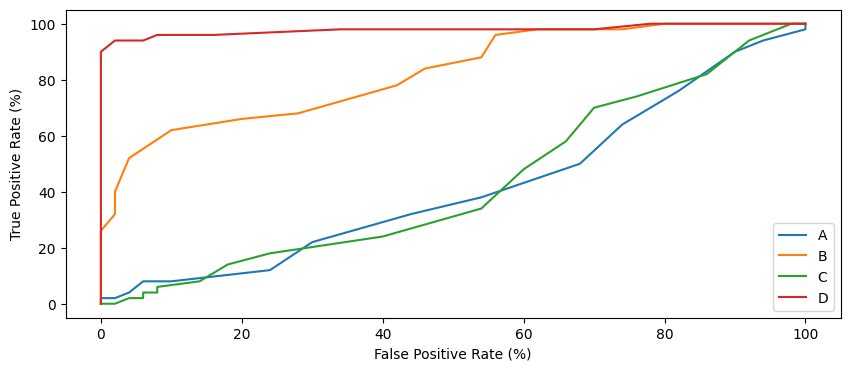

In [103]:
# Visualise predictive performance with a ROC curve
plt.plot(fpr_arr, tpr_arr)

plt.xlabel("False Positive Rate (%)")
plt.ylabel("True Positive Rate (%)")
plt.legend("ABCD")

As previously demonstrated with a threshold of 20 spikes/s, the ROC curve above illustrates that neurons D and to a less extent B provide the best early warning of a licking event occurring in the following 100 ms, whereas neurons A and C seem to fire independently of licking and thus do not represent good predictors of licking events. This can be deduced by the area under curve (AUC) of the four neurons, that is, a greater AUC is associated with a more advantageous tradeoff between a high TPR and a low FPR and thus greater discriminability between the distributions of negative (no licking) and positive events (licking). Such results are supported by the table below, where the AUCs for the four neurons are compared with one another.

In [17]:
# Compare AUCs of the four neurons
aucs = [metrics.auc(fpr_arr[:, i], tpr_arr[:, i]) for i in range(4)]
tab = {"Neuron": "ABCD", "AUC": aucs}

print(tabulate(tab, headers="keys"))

Neuron      AUC
--------  -----
A          4150
B          8238
C          4280
D          9784
